In [6]:
# Import data from featureCounts
## Previously ran at command line something like this:
## featureCounts -a genes.gtf -o counts.txt -T 12 -t exon -g gene_id *.sam

library(yaml)
rel_path = "/home/sergio/media"
tlx_list <- yaml.load_file("tracks/TLX3_list.yaml")
tlx_vs_rag <- paste(rel_path, tlx_list$table[2], sep = "")
tlx_vs_rag

[1] "/home/sergio/media/NAS3B/Bioinfoplatform/PFlab/RNA-Seq/RNA-SEQ_ANALYSIS/31-featureCounts/TLX3vsRAG_featureCounts.txt"

In [7]:
counts <- read.table(tlx_vs_rag, header=TRUE, row.names=1)

# Remove first five columns (chr, start, end, strand, length)
counts <- counts[ ,6:ncol(counts)]


In [8]:
# Convert to matrix
counts <- as.matrix(counts)
head(counts)

,R2.RAG1W.RAG1,RAGS.RAGZ,RAGZ,TLX3.1_1,TLX3.1_5,TLX3.1_P
ENSMUST00000027847,0,0,0,0,0,0
ENSMUST00000060833,0,0,0,0,0,0
ENSMUST00000166159,0,0,0,0,0,0
ENSMUST00000166860,0,0,0,0,0,0
ENSMUST00000000834,164,127,108,10,5,10
ENSMUST00000074892,0,0,0,0,0,0


In [9]:
# Assign condition (first three are controls, second three contain the expansion)
(condition <- factor(c(rep("rag", 3), rep("tlx", 3))))

[1] rag rag rag tlx tlx tlx
Levels: rag tlx

# Analysis with DESeq2 

In [10]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("DESeq2")

library(DESeq2)


# Create a coldata frame and instantiate the DESeqDataSet. See ?DESeqDataSetFromMatrix
(coldata <- data.frame(row.names=colnames(counts), condition))

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are maske

,condition
R2.RAG1W.RAG1,rag
RAGS.RAGZ,rag
RAGZ,rag
TLX3.1_1,tlx
TLX3.1_5,tlx
TLX3.1_P,tlx


In [11]:
dds <- DESeqDataSetFromMatrix(countData=counts, colData=coldata, design=~condition)
dds

# Run the DESeq pipeline
dds <- DESeq(dds)

class: DESeqDataSet 
dim: 97251 6 
metadata(1): version
assays(1): counts
rownames(97251): ENSMUST00000027847 ENSMUST00000060833 ...
  ENSMUST00000166474 ENSMUST00000175594
rowData names(0):
colnames(6): R2.RAG1W.RAG1 RAGS.RAGZ ... TLX3.1_5 TLX3.1_P
colData names(1): condition

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


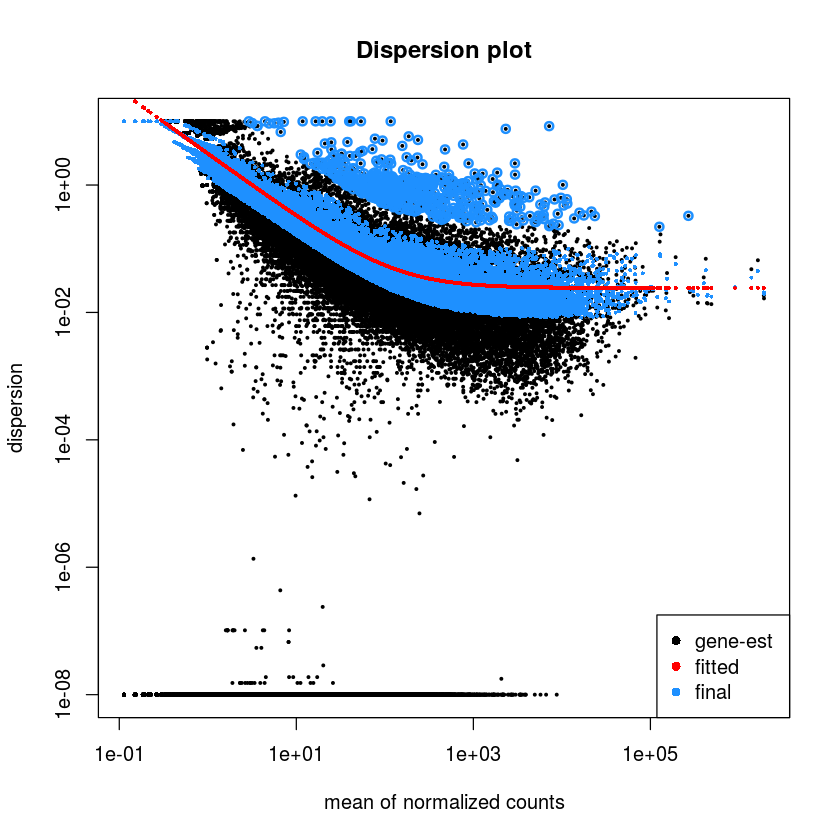

In [12]:
# Plot dispersions
#png("qc-dispersions.png", 1000, 1000, pointsize=20)
plotDispEsts(dds, main="Dispersion plot")
#dev.off()

,R2.RAG1W.RAG1,RAGS.RAGZ,RAGZ,TLX3.1_1,TLX3.1_5,TLX3.1_P
ENSMUST00000027847,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
ENSMUST00000060833,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
ENSMUST00000166159,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
ENSMUST00000166860,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
ENSMUST00000000834,6.338568,6.38816,6.190779,4.248122,3.681915,4.130365
ENSMUST00000074892,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


[1] NA

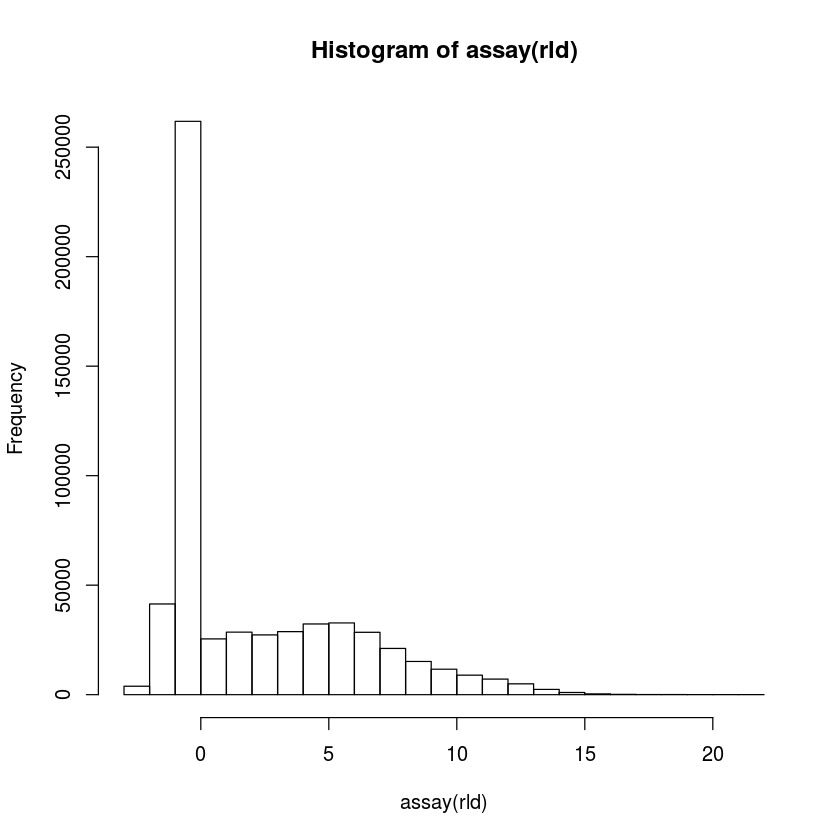

In [13]:
# Regularized log transformation for clustering/heatmaps, etc
rld <- rlogTransformation(dds)
head(assay(rld))
hist(assay(rld))


In [29]:
assay(rld)["ENSMUST00000103276", "RAGS.RAGZ"]
#rld$ENSMUST00000000834

[1] 7.191866

[1] "#1B9E77" "#D95F02"

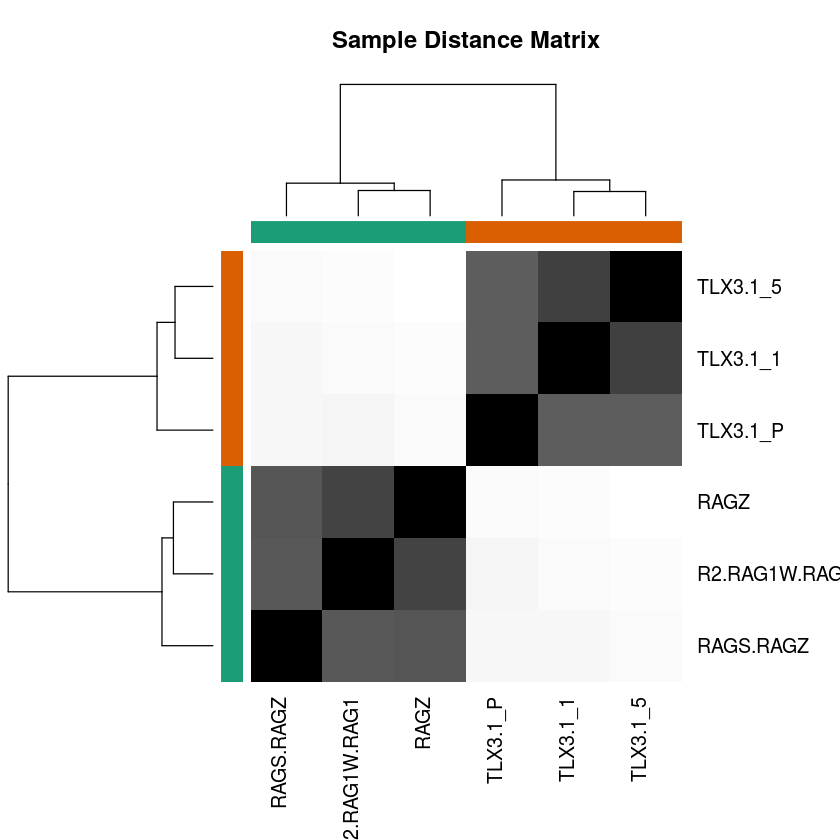

In [26]:
# Colors for plots below
## Ugly:
## (mycols <- 1:length(unique(condition)))
## Use RColorBrewer, better
library(RColorBrewer)
(mycols <- brewer.pal(8, "Dark2")[1:length(unique(condition))])

# Sample distance heatmap
sampleDists <- as.matrix(dist(t(assay(rld))))
library(gplots)
#png("qc-heatmap-samples.png", w=1000, h=1000, pointsize=20)
heatmap.2(as.matrix(sampleDists), key=F, trace="none",
          col=colorpanel(100, "black", "white"),
          ColSideColors=mycols[condition], RowSideColors=mycols[condition],
          margin=c(10, 10), main="Sample Distance Matrix")
#dev.off()

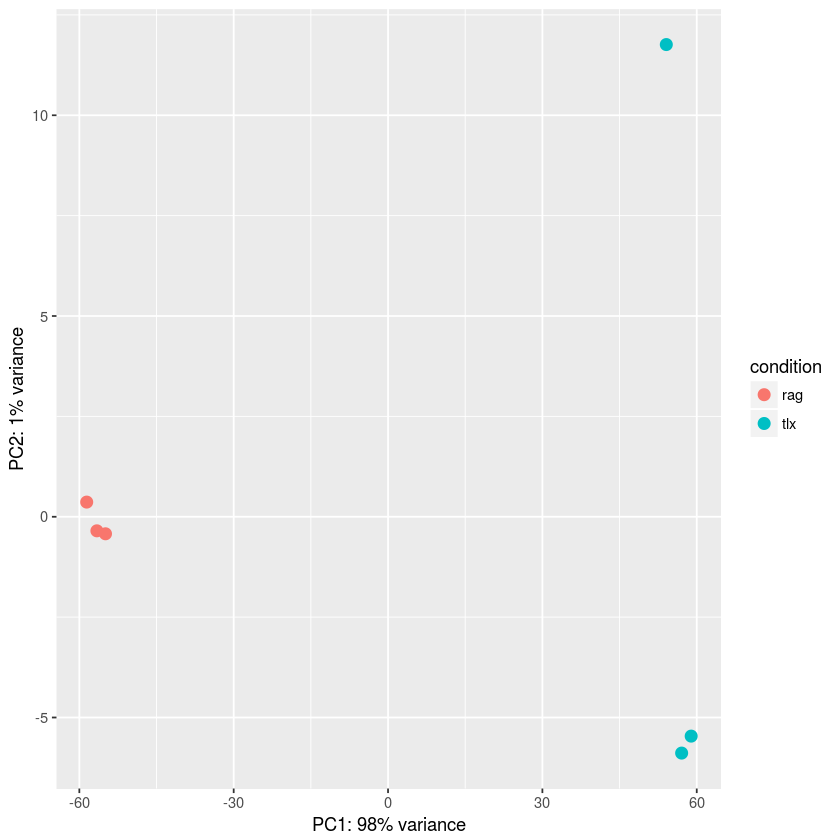

In [80]:
#install.packages("tidyverse")
library(ggplot2)
# Principal components analysis
## Could do with built-in DESeq2 function:
data <- plotPCA(rld, intgroup=c("condition"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=condition)) +
    geom_point(size=3) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) 
#+    coord_fixed()

In [ ]:
source("https://bioconductor.org/biocLite.R")
biocLite("calibrate")



In [ ]:
# Principal components analysis
## Could do with built-in DESeq2 function:
## DESeq2::plotPCA(rld, intgroup="condition")
## I like mine better:
rld_pca <- function (rld, intgroup = "condition", ntop = 500, colors=NULL, legendpos="bottomleft", main="PCA Biplot", textcx=1, ...) {
  require(genefilter)
  require(calibrate)
  require(RColorBrewer)
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca = prcomp(t(assay(rld)[select, ]))
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    }   else {
      colors = c("black", "red")
    }
  }
  pc1var <- round(summary(pca)$importance[2,1]*100, digits=1)
  pc2var <- round(summary(pca)$importance[2,2]*100, digits=1)
  pc1lab <- paste0("PC1 (",as.character(pc1var),"%)")
  pc2lab <- paste0("PC1 (",as.character(pc2var),"%)")
  plot(PC2~PC1, data=as.data.frame(pca$x), bg=colors[fac], pch=21, xlab=pc1lab, ylab=pc2lab, main=main, ...)
  with(as.data.frame(pca$x), textxy(PC1, PC2, labs=rownames(as.data.frame(pca$x)), cex=textcx))
  legend(legendpos, legend=levels(fac), col=colors, pch=20)
  #     rldyplot(PC2 ~ PC1, groups = fac, data = as.data.frame(pca$rld),
  #            pch = 16, cerld = 2, aspect = "iso", col = colours, main = draw.key(key = list(rect = list(col = colours),
  #                                                                                         terldt = list(levels(fac)), rep = FALSE)))
}
#png("qc-pca.png", 1000, 1000, pointsize=20)
rld_pca(rld, colors=mycols, intgroup="condition")
#rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-75, 35))
#dev.off()

In [33]:
# Get differential expression results
res <- results(dds)
table(res$padj<0.05)
## Order by adjusted p-value
res <- res[order(res$padj), ]
## Merge with normalized count data
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
names(resdata)[1] <- "Gene"
head(resdata)
#resdata["ENSMUST00000103276", "RAGS.RAGZ"]


FALSE  TRUE 
25702 23223 

Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,R2.RAG1W.RAG1,RAGS.RAGZ,RAGZ,TLX3.1_1,TLX3.1_5,TLX3.1_P
ENSMUST00000103276,27433.105,12.922264,0.3195134,40.44358,0.000000e+00,0.000000e+00,10.17785,3.674556,4.499572,53775.67733,52859.66527,57944.93574
ENSMUST00000103553,3762.701,4.555680,0.1280525,35.57665,3.217765e-277,7.871458e-273,303.97855,304.069541,308.670611,7628.70803,7078.49457,6952.28276
ENSMUST00000001327,21480.430,3.850095,0.1148152,33.53298,1.594072e-246,2.599666e-242,2857.26266,2862.479424,2612.451264,40286.99609,40462.51650,39800.87573
ENSMUST00000058845,4942.879,4.063601,0.1213777,33.47898,9.751199e-246,1.192694e-241,571.31683,561.288488,534.549105,8956.21833,9427.63398,9606.26623
ENSMUST00000109488,3293.419,-7.777488,0.2328029,-33.40803,1.048078e-244,1.025544e-240,7110.24827,5760.785772,6801.552411,37.08844,25.32144,25.51907
ENSMUST00000009058,3446.295,4.020143,0.1204048,33.38856,2.009677e-244,1.638724e-240,401.68594,388.584338,405.861357,6594.06850,6451.21334,6436.35370


In [38]:
resdata$RAGS.RAGZ[5]

[1] 5760.786

In [71]:
## Write results
#write.csv(resdata, file="TLX3vsRAG_DESeq2-results.csv")
write.table(resdata, file="TLX3vsRAG_DESeq2-results.txt", row.names = FALSE, quote = FALSE, sep = "\t")

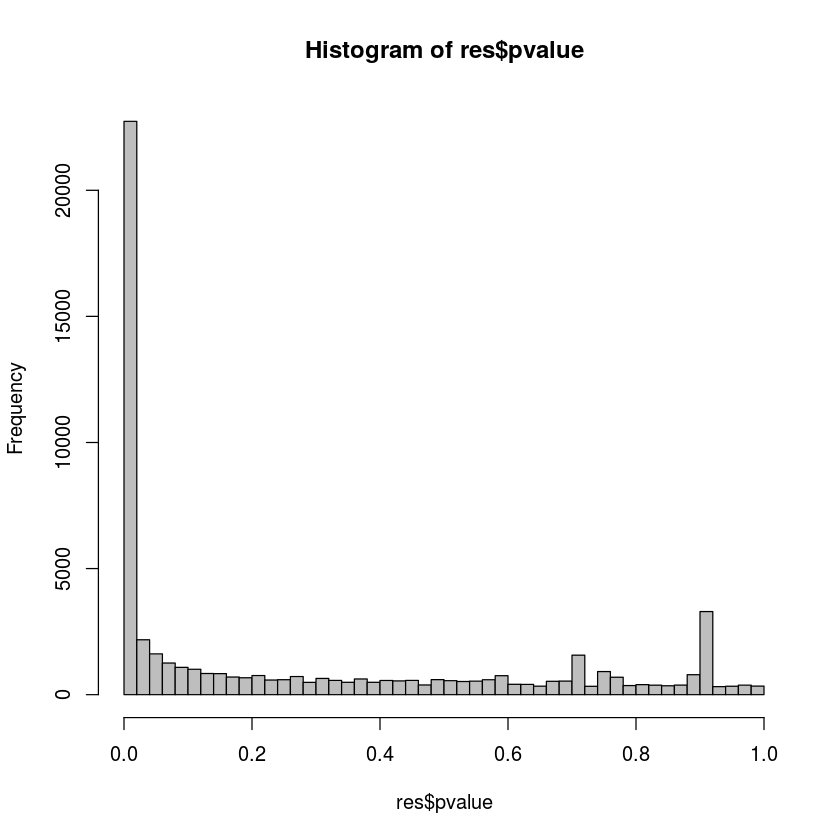

In [35]:
## Examine plot of p-values
hist(res$pvalue, breaks=50, col="grey")

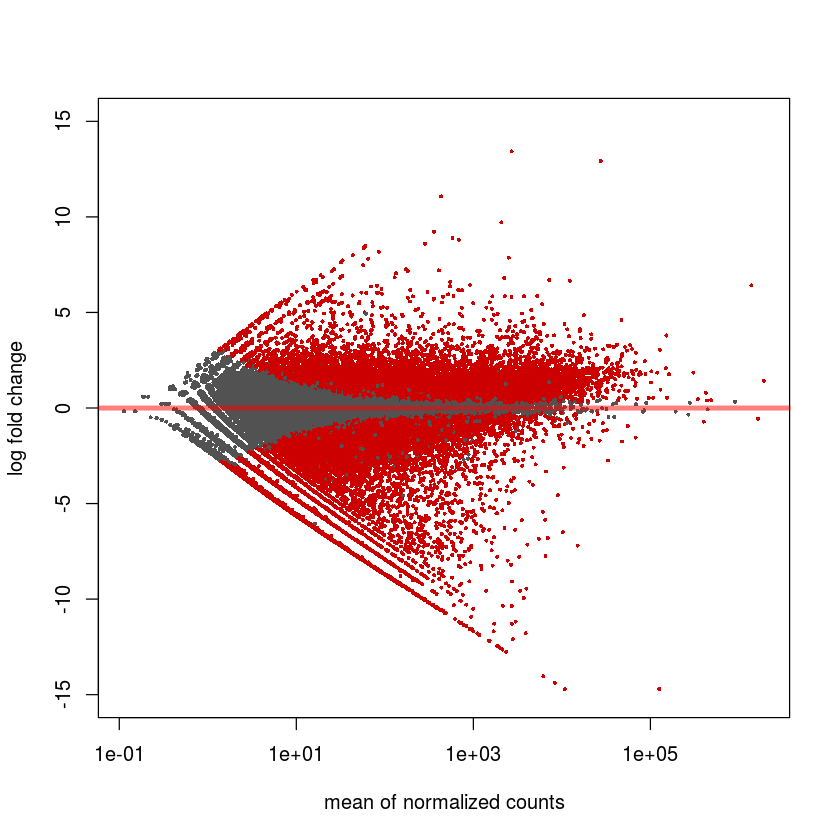

In [49]:
## MA plot
## Could do with built-in DESeq2 function:
DESeq2::plotMA(dds,  ylim=c(-15,15), cex=1)
 #DESeq2::plotMA(dds, ylim=c(-1,1), cex=1)
#identify

In [ ]:
## I like mine better:
maplot <- function (res, thresh=0.05, labelsig=TRUE, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    require(calibrate)
    #with(subset(res, padj<thresh), textxy(baseMean, log2FoldChange, labs=Gene, cex=textcx, col=2))
  }
}
#png("diffexpr-maplot.png", 1500, 1000, pointsize=20)
maplot(resdata, main="MA Plot")
#dev.off()


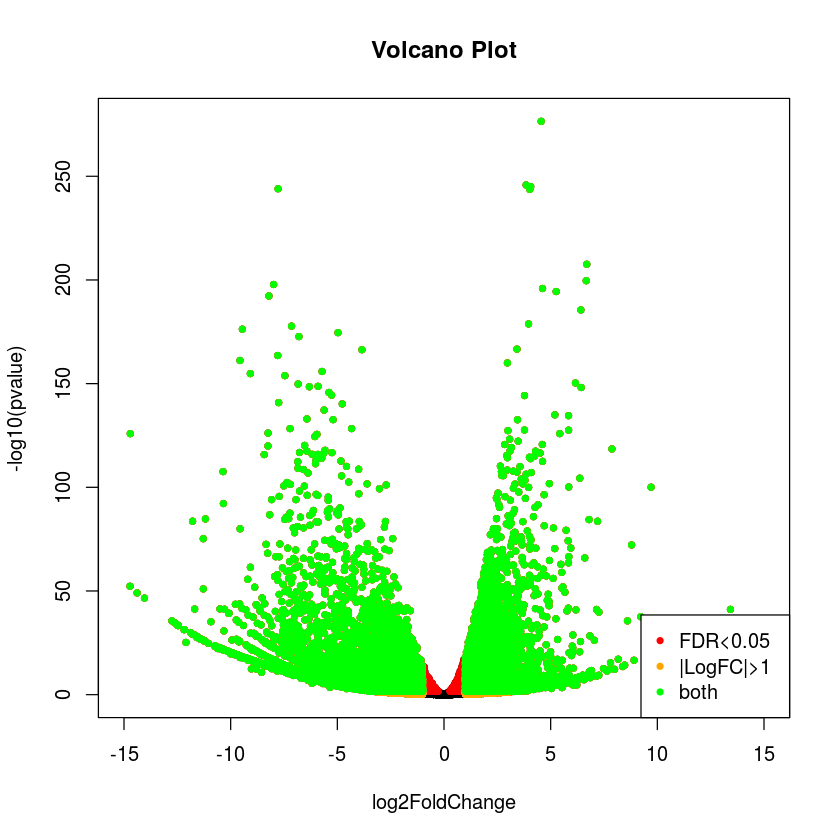

In [46]:
## Volcano plot with "significant" genes labeled
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.05, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    require(calibrate)
    #with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), textxy(log2FoldChange, -log10(pvalue), labs=Gene, cex=textcx, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
}
#png("diffexpr-volcanoplot.png", 1200, 1000, pointsize=20)
volcanoplot(resdata, lfcthresh=1, sigthresh=0.05, textcx=.8, xlim=c(-15, 15))

#dev.off()

In [51]:
source("https://bioconductor.org/biocLite.R")
biocLite("pheatmap")
library("pheatmap")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) ‘pheatmap’
installation path not writeable, unable to update packages: RSQLite
Old packages: 'ChIPpeakAnno', 'tidyr'


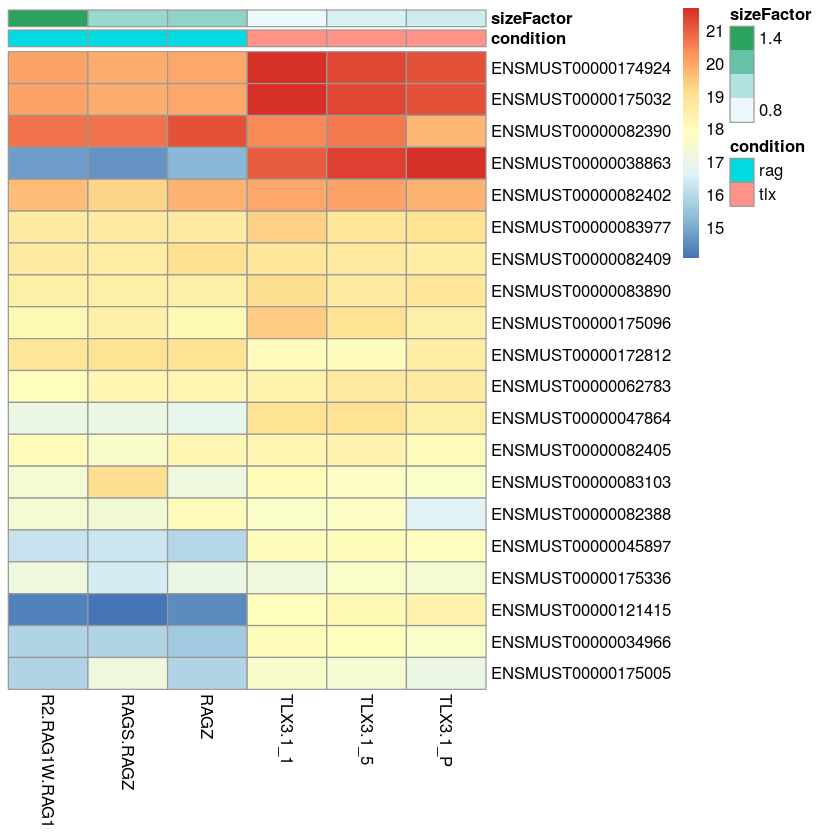

In [69]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),
decreasing=TRUE)[1:20]
nt <- normTransform(dds) # defaults to log2(x+1)
log2.norm.counts <- assay(nt)[select,]

df <- as.data.frame(colData(dds))

#pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
#cluster_cols=FALSE, annotation_col=df)

pheatmap(log2.norm.counts, cluster_rows=FALSE, show_rownames=TRUE, cluster_cols=FALSE, annotation_col=df)

In [60]:
select

[1] 20517 20528 92069 89791 92081 29259 92088 49069 26767 41635 35579  7105
[13] 92084 91225 92067  1320 70349 56067 88997 75542